In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # magic 커맨드 설정 없이 바로 그래프 그릴 수 있도록 설정

In [2]:
train_data_path = join('./data', 'train.csv')
test_data_path = join('./data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.shape, test.shape

((15035, 21), (6468, 20))

In [3]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
del train['id']
train['price'] = np.log1p(train['price'])
# y 변수에 price 값 저장, train 데이터에서 price값 안지움
y = train['price']

In [4]:
train.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,201438.545993,13.048122,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,44.252050,0.527471,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,201405.000000,11.264477,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,201407.000000,12.682310,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,201410.000000,13.017005,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,201502.000000,13.377007,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,201505.000000,15.856731,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

In [6]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## step1 Feature data visualization
__상관관계를 알아보는 함수는 두 가지가 있음__
1. 피어슨 상관관계 : 연속형 변수
2. 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우 사용

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<Axes: >

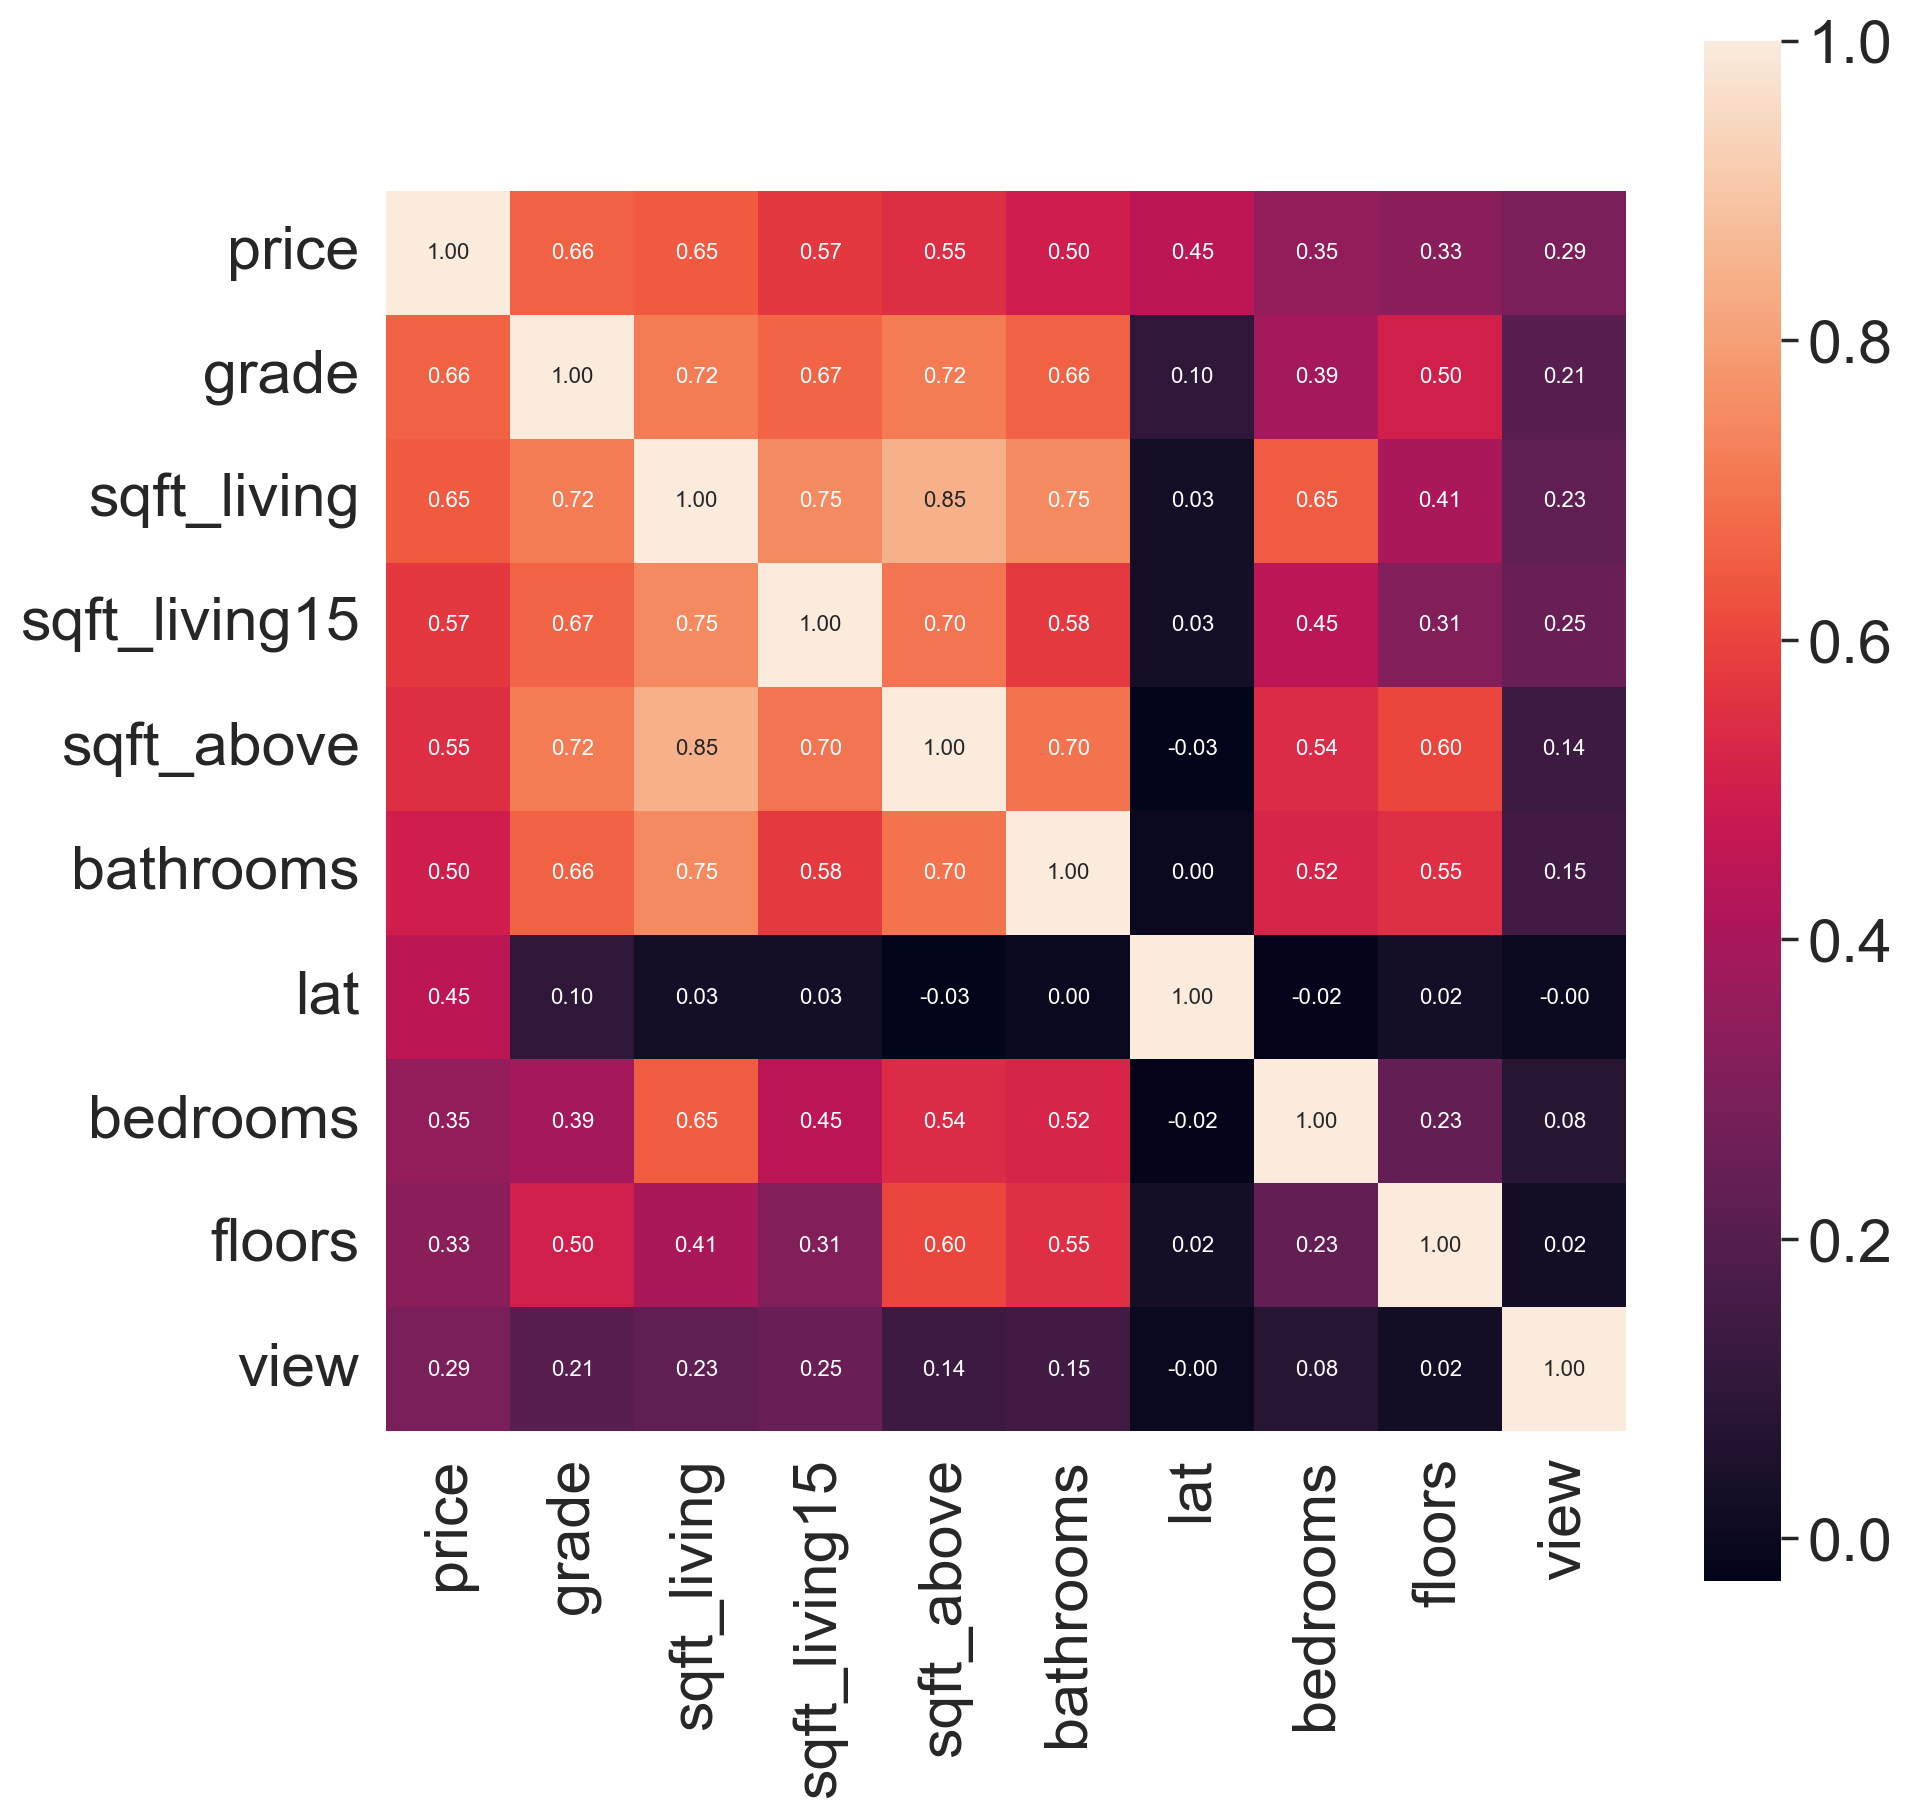

In [7]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
# price와 correlation이 높은 column 10개 뽑기(내림차순)
cor_cols = cor_abs.nlargest(n=10, columns='price').index

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8},
           xticklabels=cor_cols.values, yticklabels=cor_cols.values)

타겟 데이터인 price와 상관관계가 높은 변수는 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms' 'lat' 'bedrooms' 'floors' 'view' 즉, 집의 등급, 주거 공간의 평방 면적, 2015년 기준 주거 공간의 평방 면적, 지하실을 제외한 평방 면적, 화장실 개수, 위도, 침실 개수, 집의 층수, view 순서임.

__집 등급별(grade) 가격을 box plot으로 시각화__

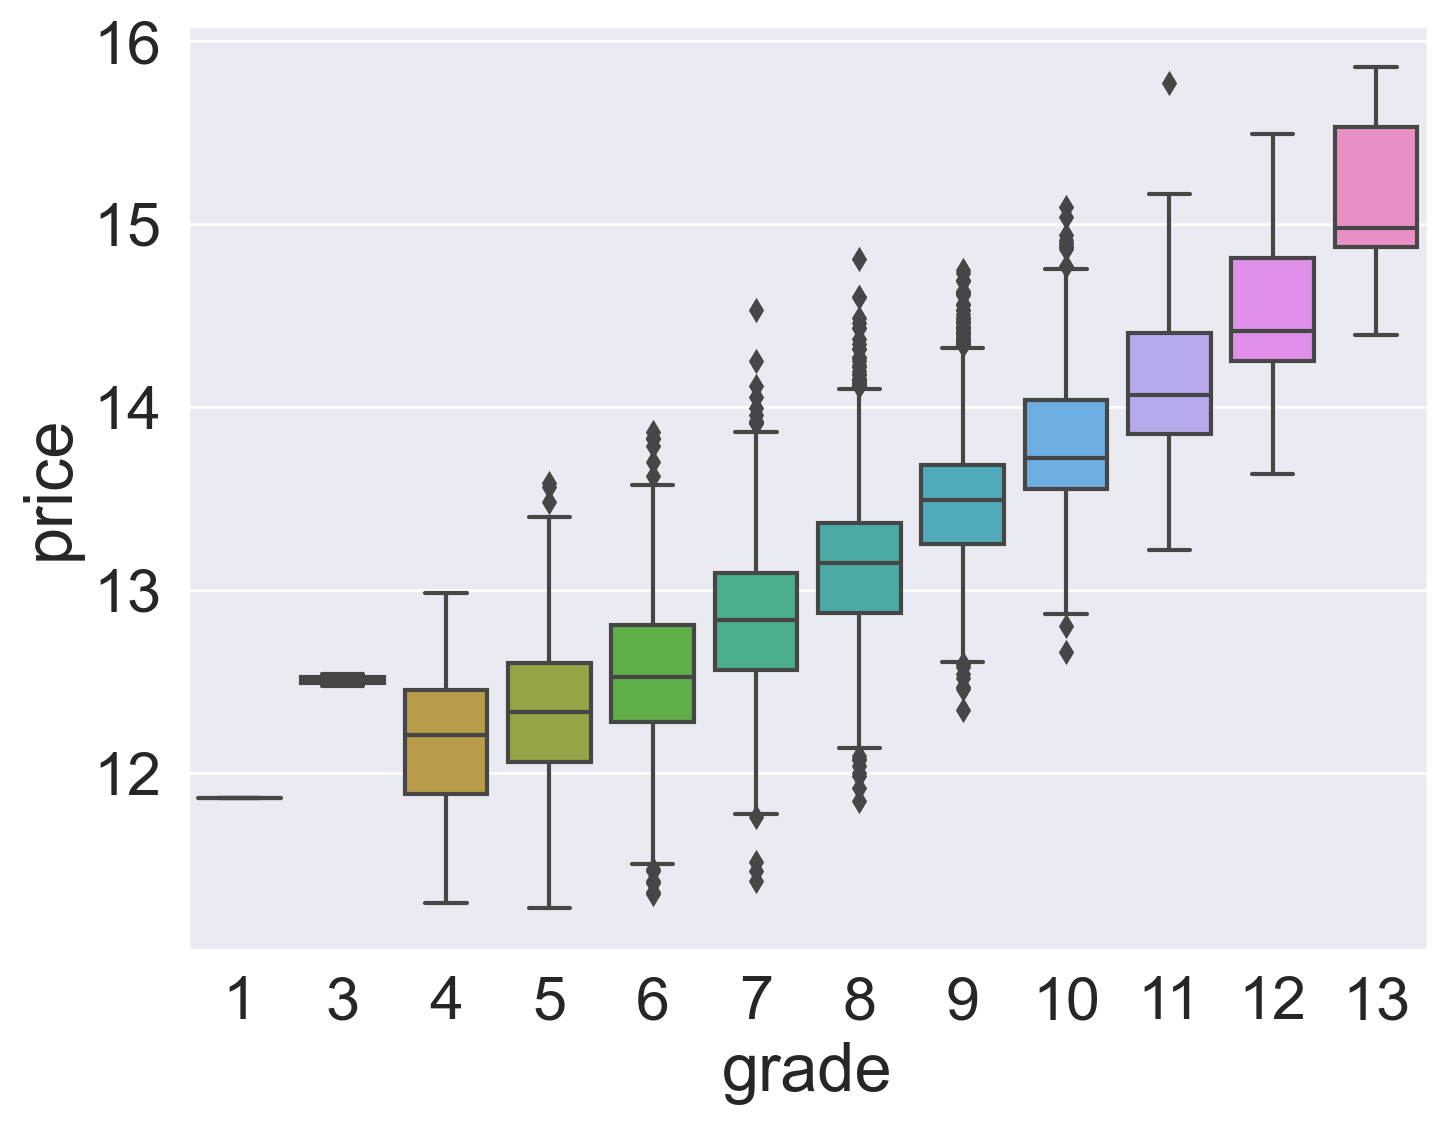

In [8]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

집의 등급이 높을수록 가격이 높아짐. 히트맵 결과와 correlation 되는 부분.
* 등급 3의 집값이 등급 4, 5, 6의 IQR 75% 보다 조금 높거나 비슷한 값을 가짐.
* 등급 7~11은 이상치가 많음
* 등급 7, 8, 11, 12에서 차이가 큰 이상치가 나타남
* 등급 13은 분산이 매우 큼

__주거공간 면적(sqft_living)과 집값 시각화__

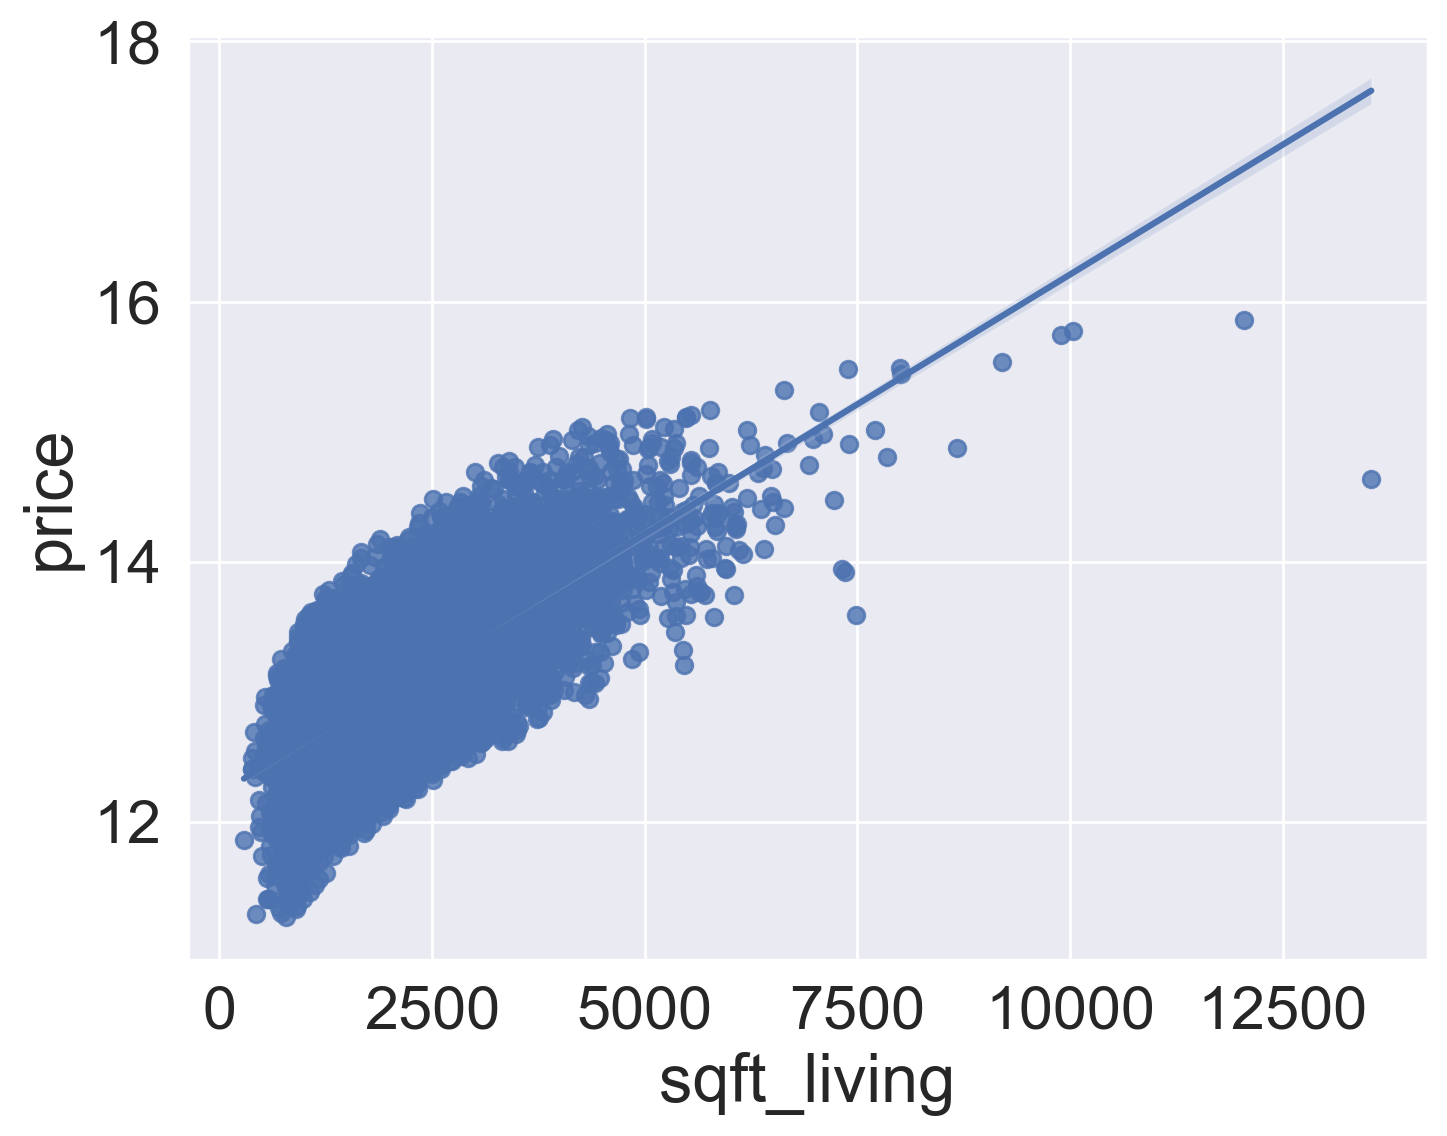

In [9]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

전반적으로 선형성을 보이지만, 집값 14~15 사이에 12500을 넘는 면적을 가진 집이 존재함 (이상치로 보임)

__15년 이후 주거공간 면적(sqft_living15)과 집값 시각화__

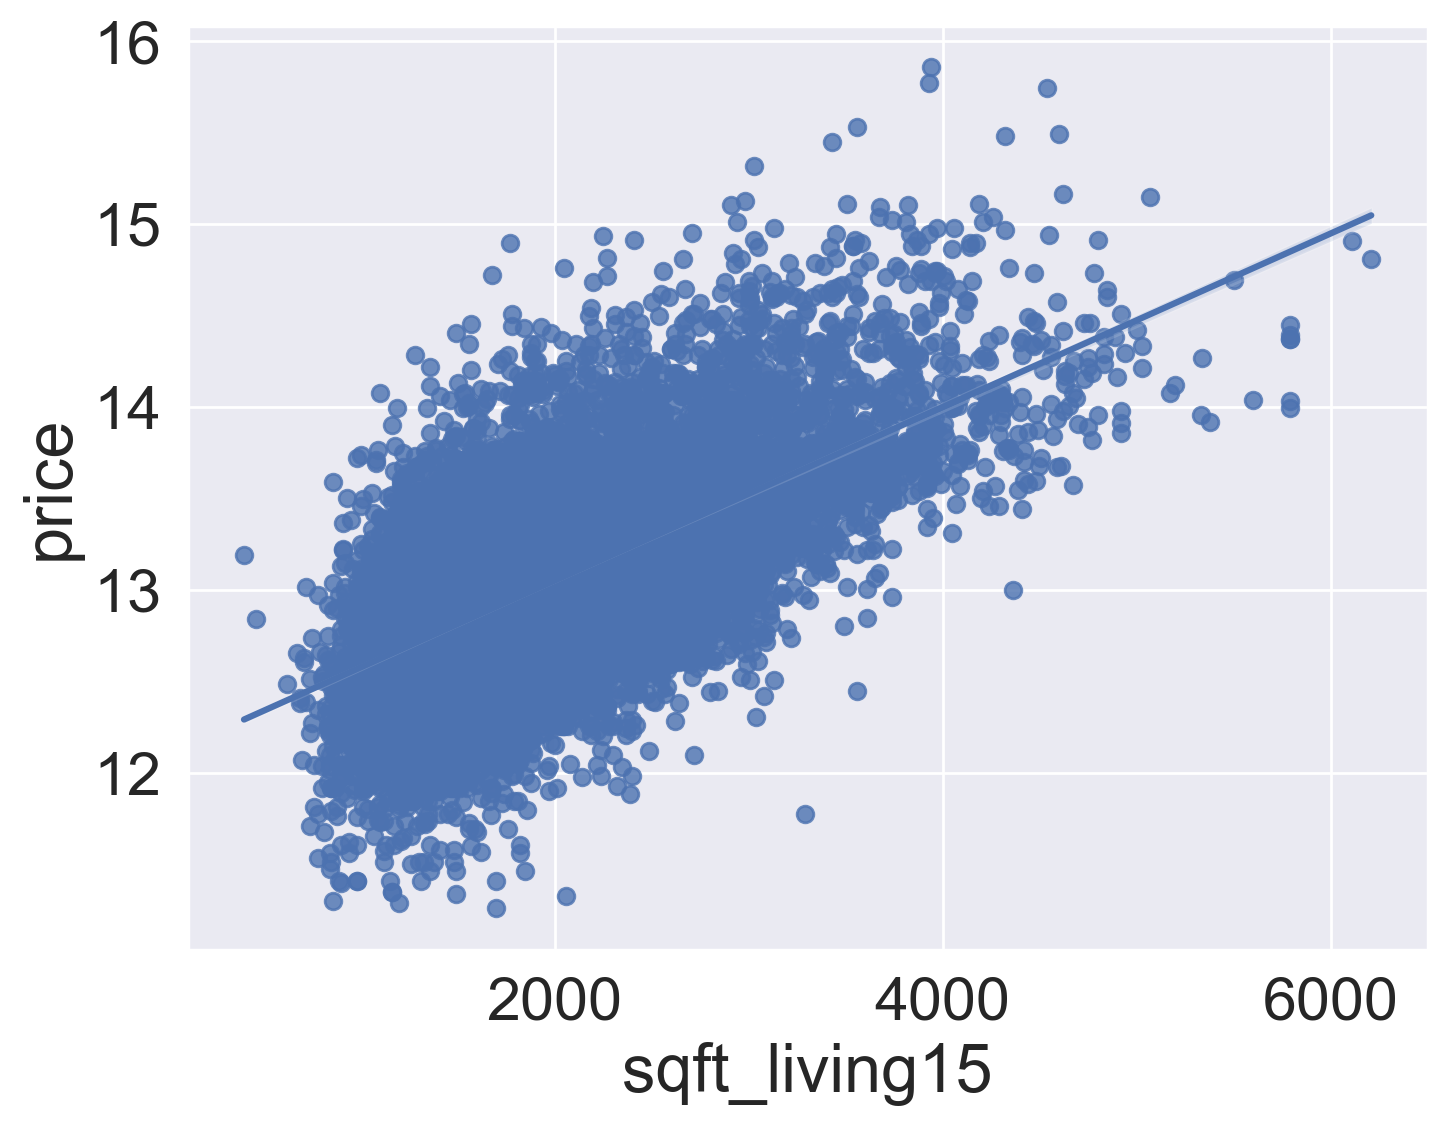

In [10]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

이전 데이터에 비해 가격의 분산이 큼. 재건축으로 인한 영향이라고 볼 수 있음

__지하실 제외한 면적(sqft_above)과 집값 시각화__

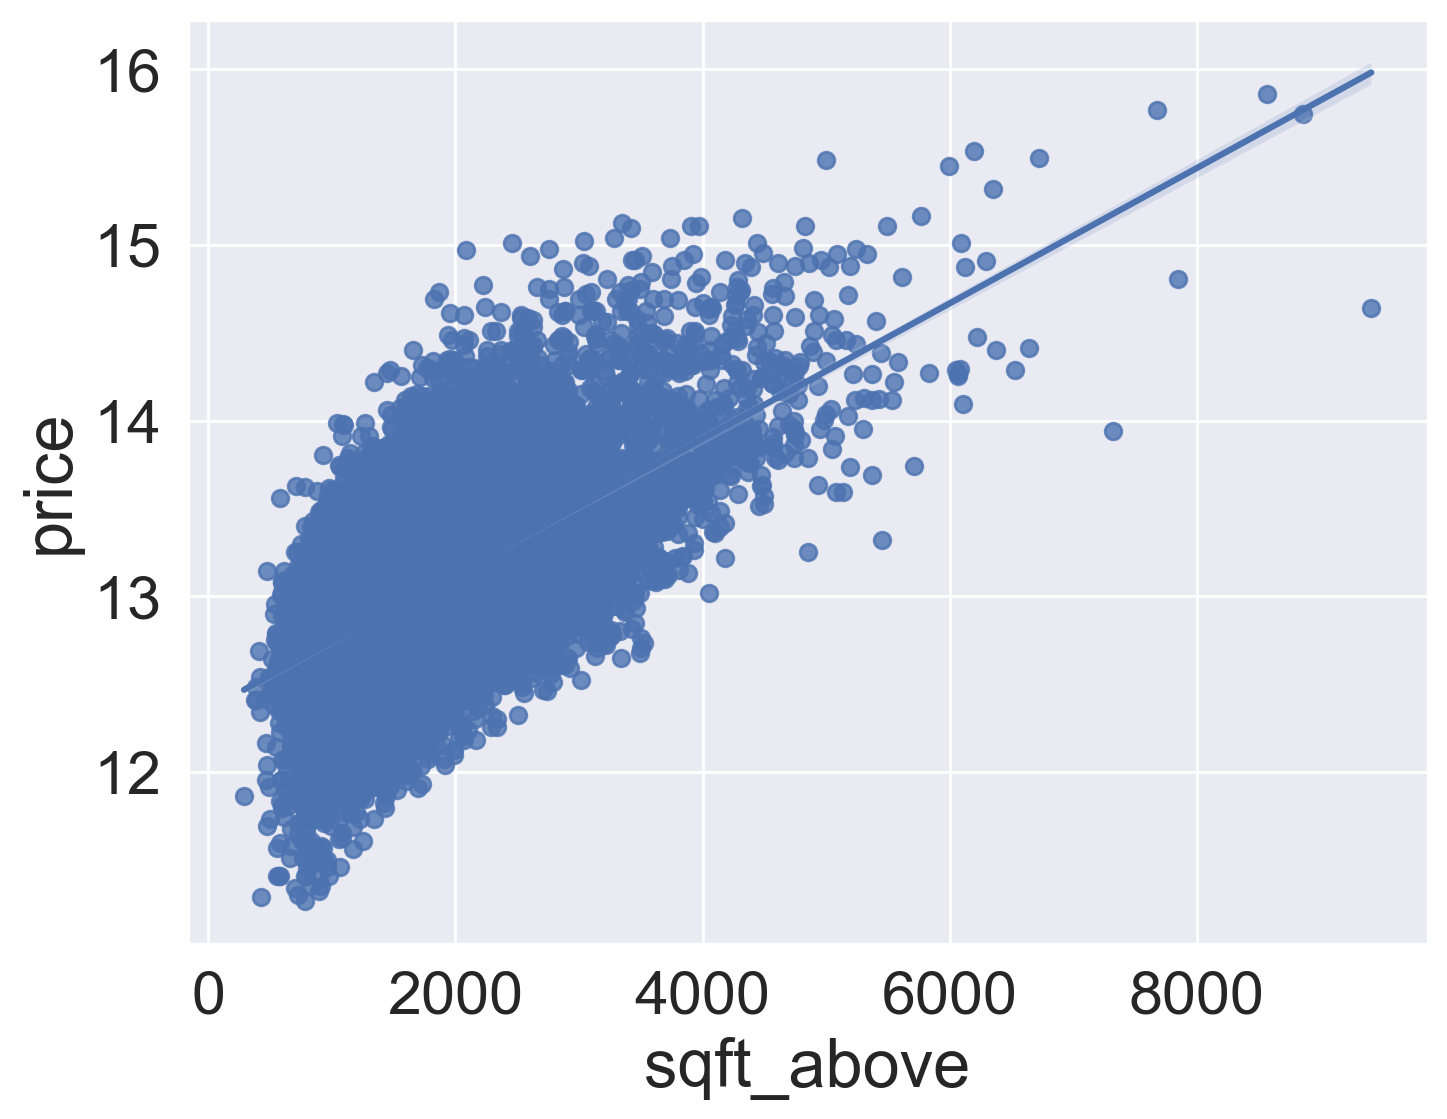

In [11]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

__화장실 개수와 집값 시각화__

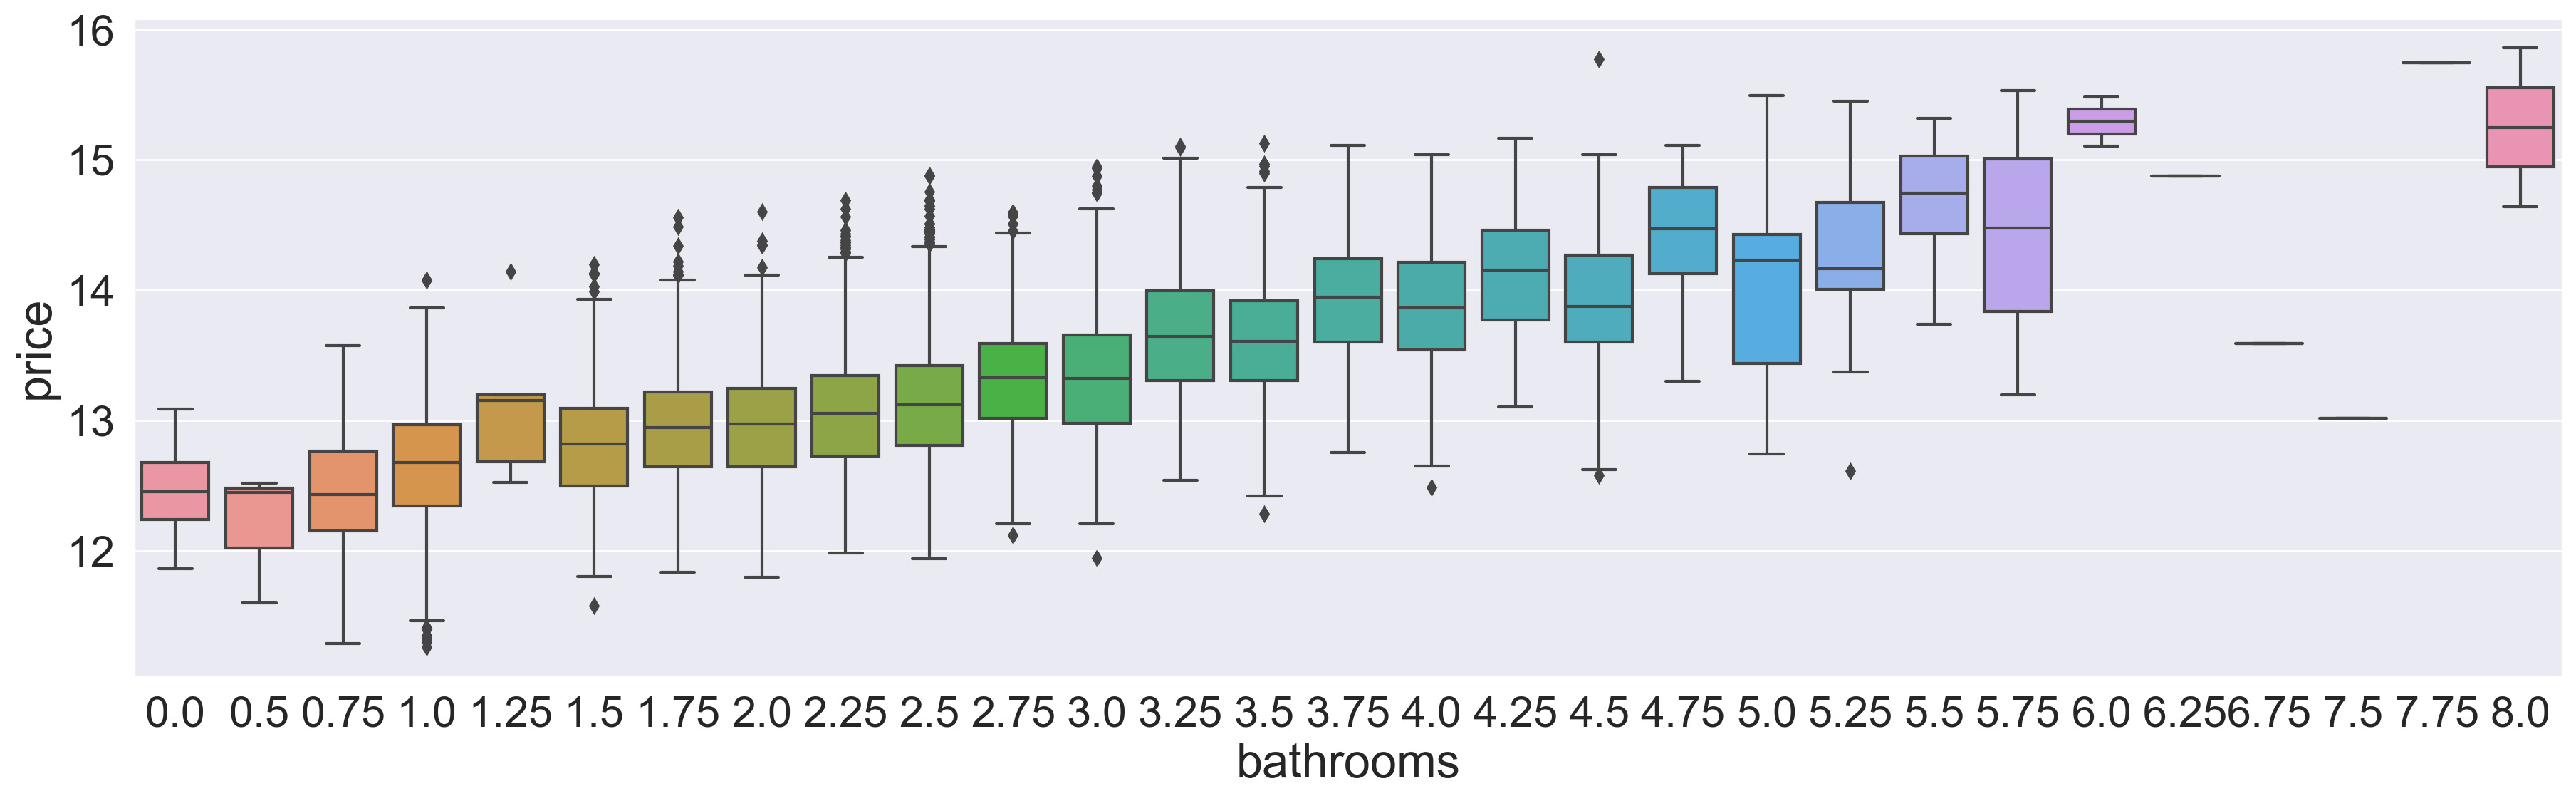

In [12]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(22, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)


1. 각각의 수치가 의미하는 바는 아래와 같음
    * 0.5 : 세면대, 화장실
    * 0.75 : 세면대, 화장실, 샤워실
    * 1 : 세면대, 화장실, 샤워실, 욕조
2. 대체로 개수가 많을수록 집값이 증가하는 양상을 보이나, 화장실 6.25 ~ 7.5개를 갖는 집은 개수 대비 오히려 낮은 가격을 가짐

__침실 개수와 집값 시각화__

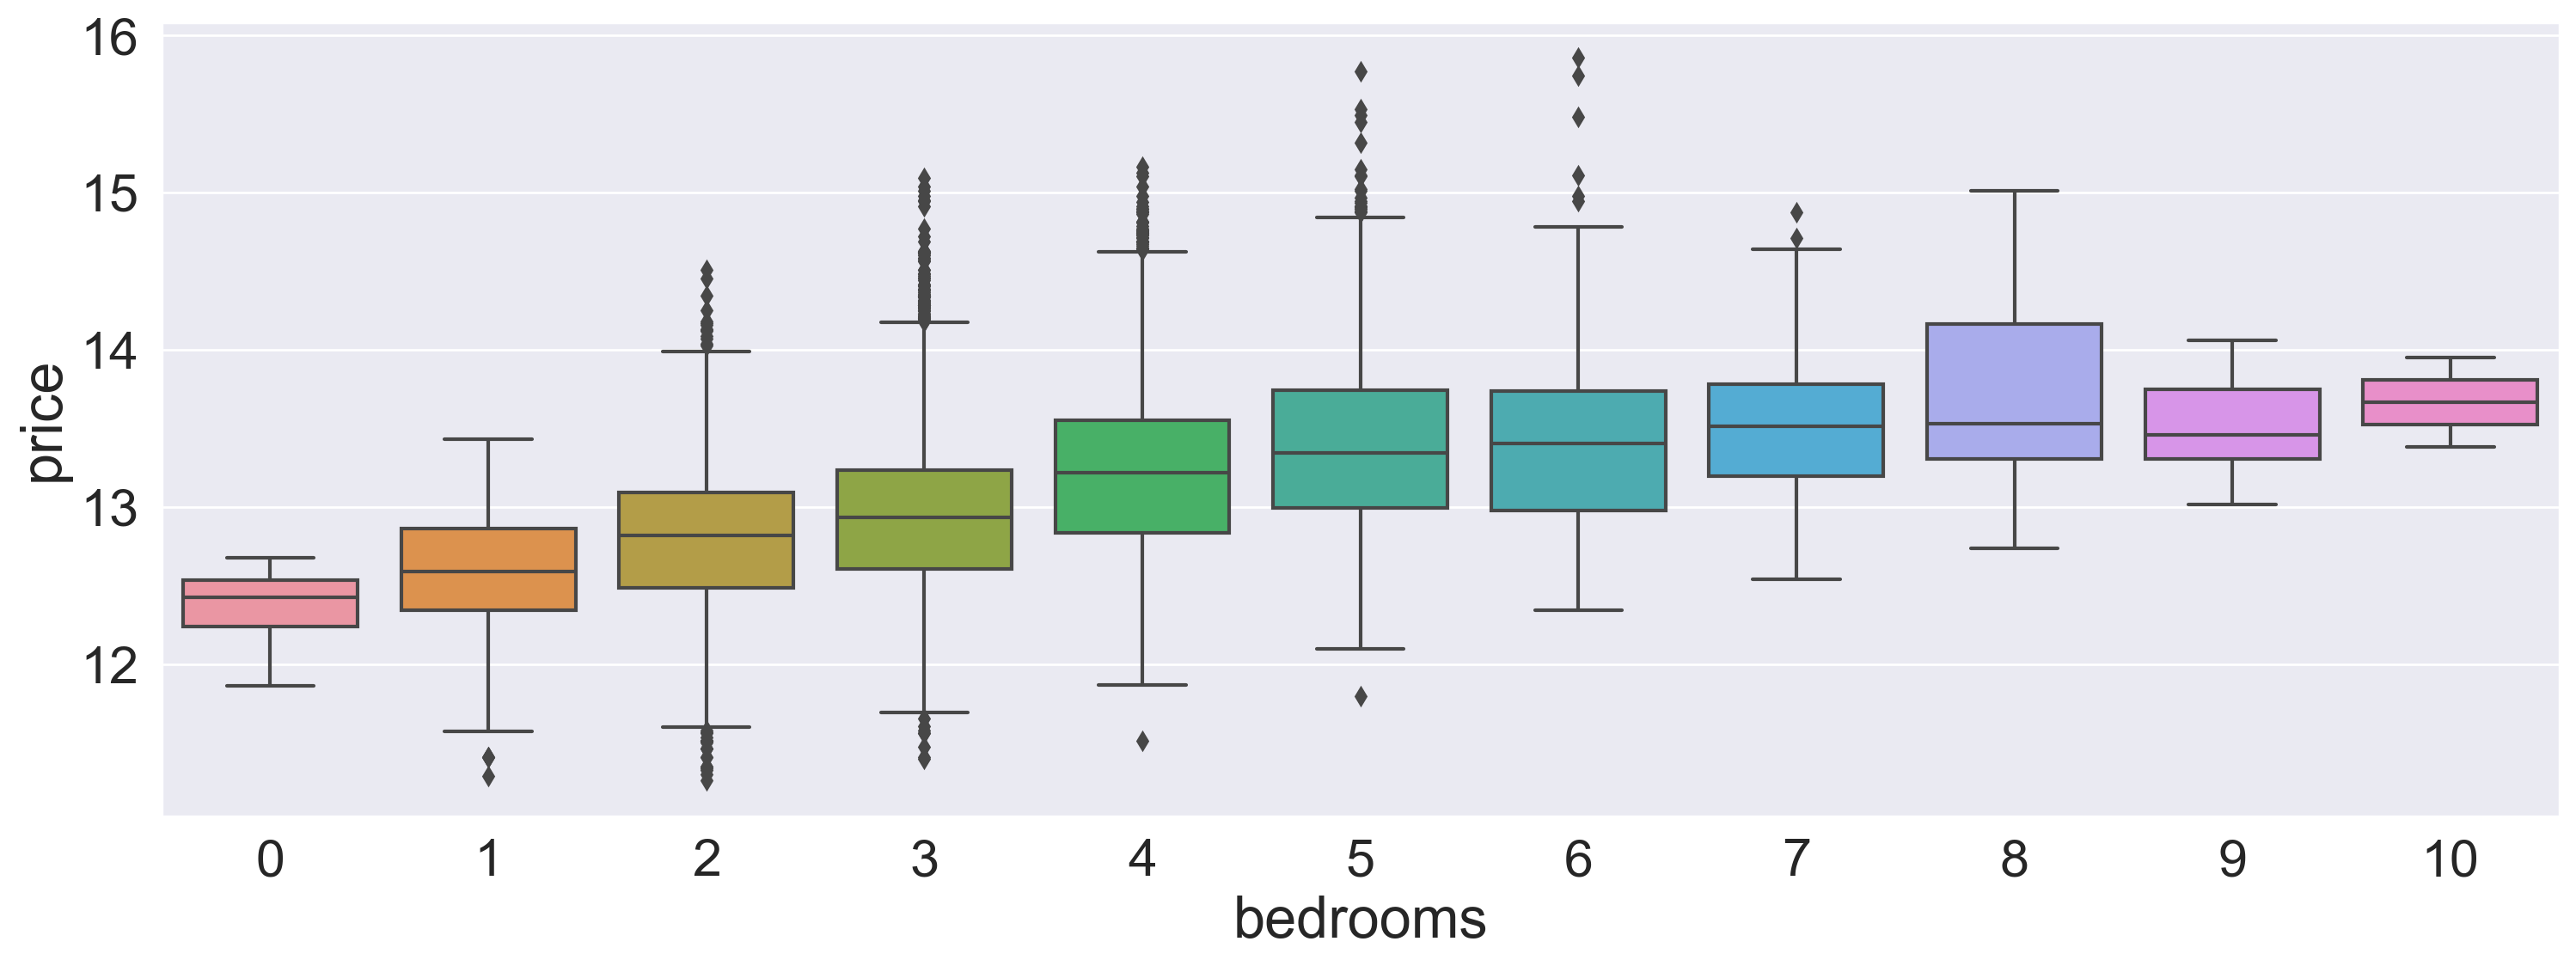

In [13]:
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

* 침실 개수가 증가할수록 집값이 대체로 상승함. 침실 개수가 2~5개인 집은 이상치가 매우 많음
* 방 개수에 따른 중앙값이 대체로 비슷함.
* 방 개수가 적어도 비싼 집이 많음

---

## step2 Data preprocessing

### 1. 이상치 제거
위 시각화 자료에서 이상치가 있는 Feature는 'grade', 'sqft living', 'bathrooms', 'bedrooms' 이다.

__1.1 Grade__

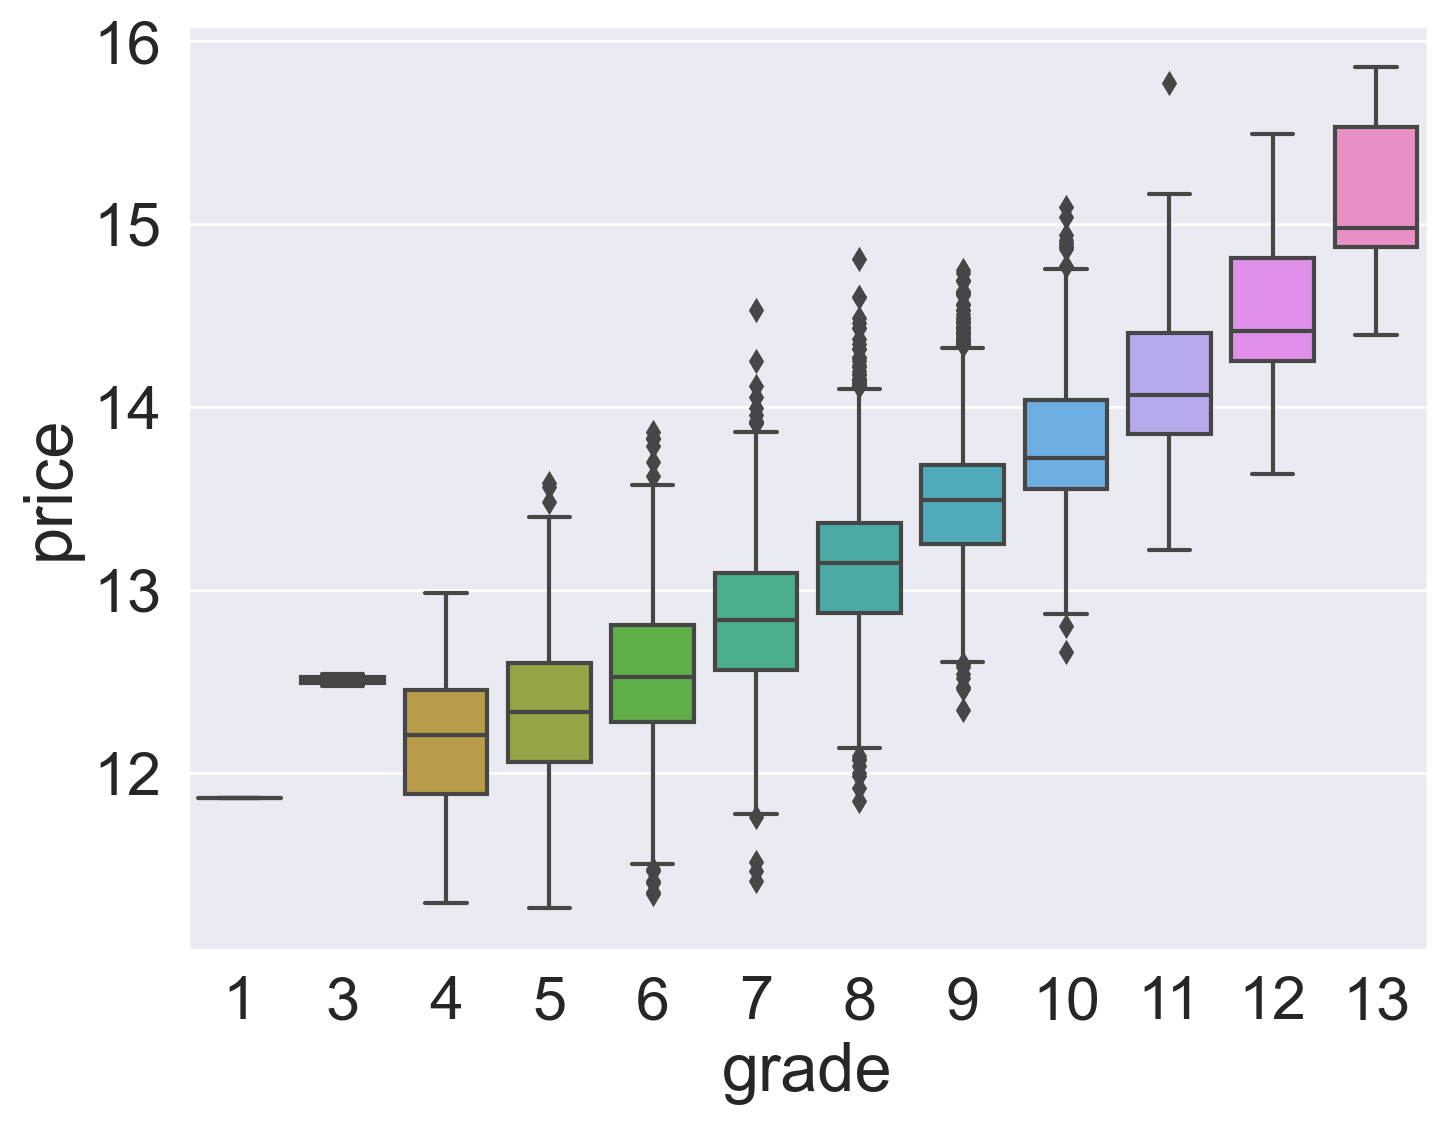

In [14]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [15]:
train.loc[(train['price']>14.5) & (train['grade'] == 7)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,201501,14.533351,4,3.25,3580,19989,1.5,1,4,4,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [16]:
train.loc[(train['price']>14.7) & (train['grade'] == 8)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,201408,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [17]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


위와 같이 grade 7, 8, 11에서 유독 값이 비싼 세개 항목은 이상치로 규정하고 제거함

In [18]:
train.drop([12346, 7173, 2775], axis=0, inplace=True)

__1.2 sqft living__

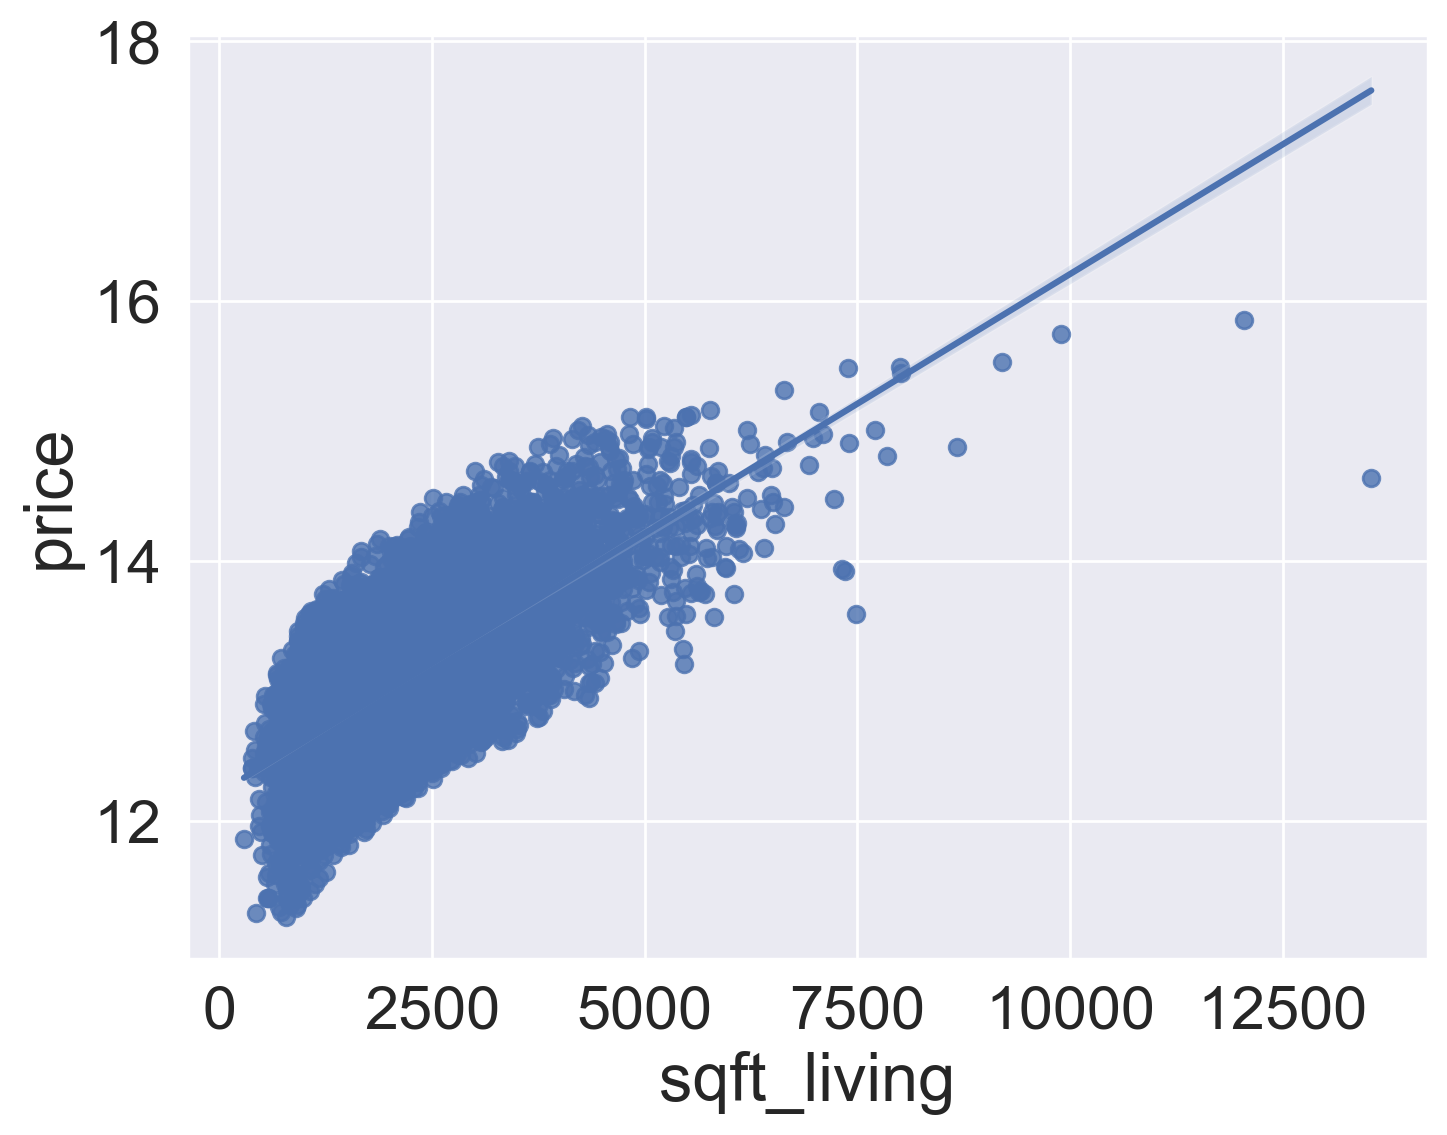

In [19]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [20]:
train.loc[train['sqft_living'] > 12500]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [21]:
train.drop([8912], axis=0, inplace=True)

__1.3 bathrooms__

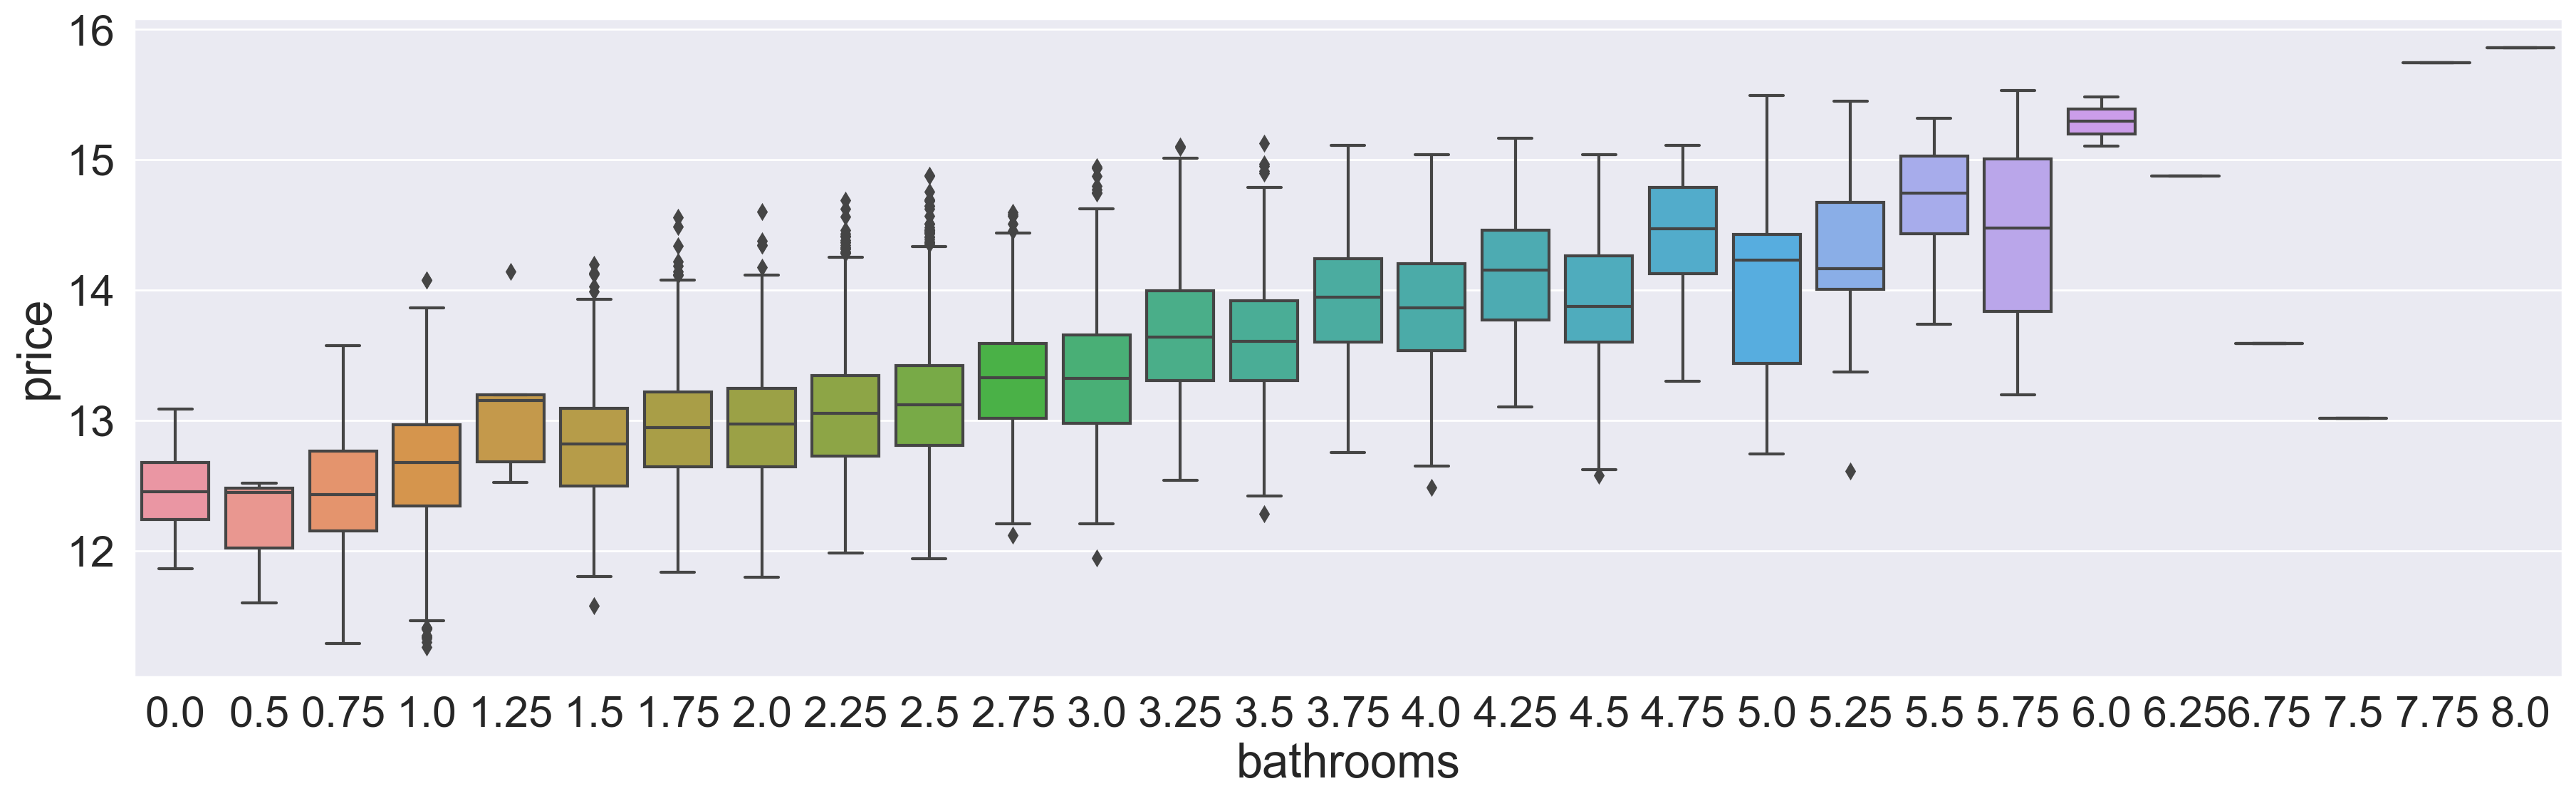

In [22]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(22, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

In [23]:
train.loc[(train['price'] > 14) & (train['bathrooms'] ==1.0)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5858,201407,14.077876,5,1.0,1670,6400,1.5,0,0,3,8,1670,0,1919,0,98119,47.6542,-122.373,1910,2983
6666,201503,14.077876,3,1.0,2040,7936,1.0,0,3,5,8,1680,360,1940,0,98177,47.7028,-122.385,2300,10080


In [24]:
train.loc[(train['price'] > 14) & (train['bathrooms'] ==1.25)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12969,201411,14.143375,3,1.25,2400,6653,3.0,0,2,3,11,2400,0,1992,0,98122,47.6019,-122.29,1910,6653


In [25]:
train.loc[(train['price'] < 11.7) & (train['bathrooms'] ==1.5)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8630,201408,11.580593,3,1.5,910,5120,1.0,0,0,3,6,910,0,1973,0,98106,47.5238,-122.356,1410,5132


In [26]:
train.loc[(train['price'] < 12) & (train['bathrooms'] ==3.0)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
11144,201410,11.944714,3,3.0,1530,9997,1.0,0,0,3,6,1020,510,1992,0,98001,47.2861,-122.252,1410,9997


In [27]:
train.loc[(train['price'] < 12.4) & (train['bathrooms'] ==3.5)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7969,201410,12.286043,3,3.5,1480,1077,2.0,0,0,3,7,1300,180,2007,0,98109,47.5421,-122.322,1140,2003


In [28]:
train.loc[(train['price'] < 12.5) & (train['bathrooms'] ==4.0)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6039,201408,12.487489,5,4.0,1400,8580,1.0,0,0,5,7,900,500,1954,0,98188,47.456,-122.292,1220,8832


In [29]:
train.loc[(train['price'] < 13) & (train['bathrooms'] ==5.25)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
11701,201405,12.611541,6,5.25,2860,5682,2.0,0,0,3,7,2860,0,1978,0,98002,47.303,-122.221,1390,5956


In [30]:
train.drop([5858, 6666, 12969, 8630, 11144, 7969, 6039, 11701], axis=0, inplace=True)

In [31]:
train.loc[train['bathrooms']>6.1]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2859,201410,13.592368,7,6.75,7480,41664,2.0,0,2,3,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190
5108,201410,15.856731,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
5990,201408,13.017005,9,7.50,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866
6469,201409,15.744856,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
10152,201406,14.876075,5,6.25,8670,64033,2.0,0,4,3,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021


화장실 개수가 6.25, 6.75, 7.5는 경향을 크게 벗어나므로 삭제

In [32]:
train.drop([2859, 5990, 10152], axis=0, inplace=True)

__1.4 bedrooms__

앞선 언급했듯, 중앙값이 침실개수가 증가함에 따라 양의 상관관계를 보이므로 이상치를 따로 처리하지 않음

### 2. 정규화
* 초반에 train.describe()을 보면 6가지 feature('sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15' ,'sqft_lot15')값의 스케일이 다른 feature와 비교했을 때 매우 큼을 알 수 있음. 때문에 정규화 과정이 필요함.


 유니크값을 아래와 같이 확인했을때, 'waterfront'는 있다 없다를 상징하며, 'view'는 grade과 같이 순위형 변수일 것이라고 예상됨.

In [33]:
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

In [34]:
unique_train

,Columns,Unique_value
0,bedrooms,11
1,bathrooms,26
2,floors,6
3,waterfront,2
4,view,5
5,condition,5
6,grade,12


정규화를 진행하기에 앞서 __카테고리형 feature 데이터를 연속적 실수값을 갖는 feature 데이터와 함께 정규화를 시켜도 되는지 의문임__
* 집값과 높은 상관관계를 갖는 feature는 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms' 'lat' 'bedrooms' 'floors' 'view'이고, 이 중 스케일이 큰 feature는 'sqft_living' 'sqft_living15' 'sqft_above'임.
* 데이터를 학습할 때, 스케일이 큰 feature의 중요도가 과중되는 문제로 인해 정규화를 진행하는데, 상관관계가 높은 feature 중 다수가 스케일이 큼. 그렇담 굳이 정규화를 할 필요가 없는거 아닐까?
* 정규화를 안하면 스케일이 작고, 심지어 카테고리형 feature인 'grade', 'bathrooms', 'bedrooms', 'floors', 'view' 항목들은 힘을 못쓰고 묻혀버리는게 아닐까?
* 해당 내용은 추후에 직접 돌려서 확인해볼 예정.
* 일단 정규화는 진행하지 않음

### 3. Feature 변경

In [35]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [36]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [37]:
for df in [train,test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [38]:
train.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated'],
      dtype='object')

In [39]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated'],
      dtype='object')

Feature를 새로 생성한 뒤, 집값과의 상관계수 변화가 있는지 확인해봄

['price' 'grade' 'sqft_living' 'sqft_total_size' 'sqft_living15'
 'sqft_above' 'bathrooms' 'total_rooms' 'lat' 'bedrooms']


<Axes: >

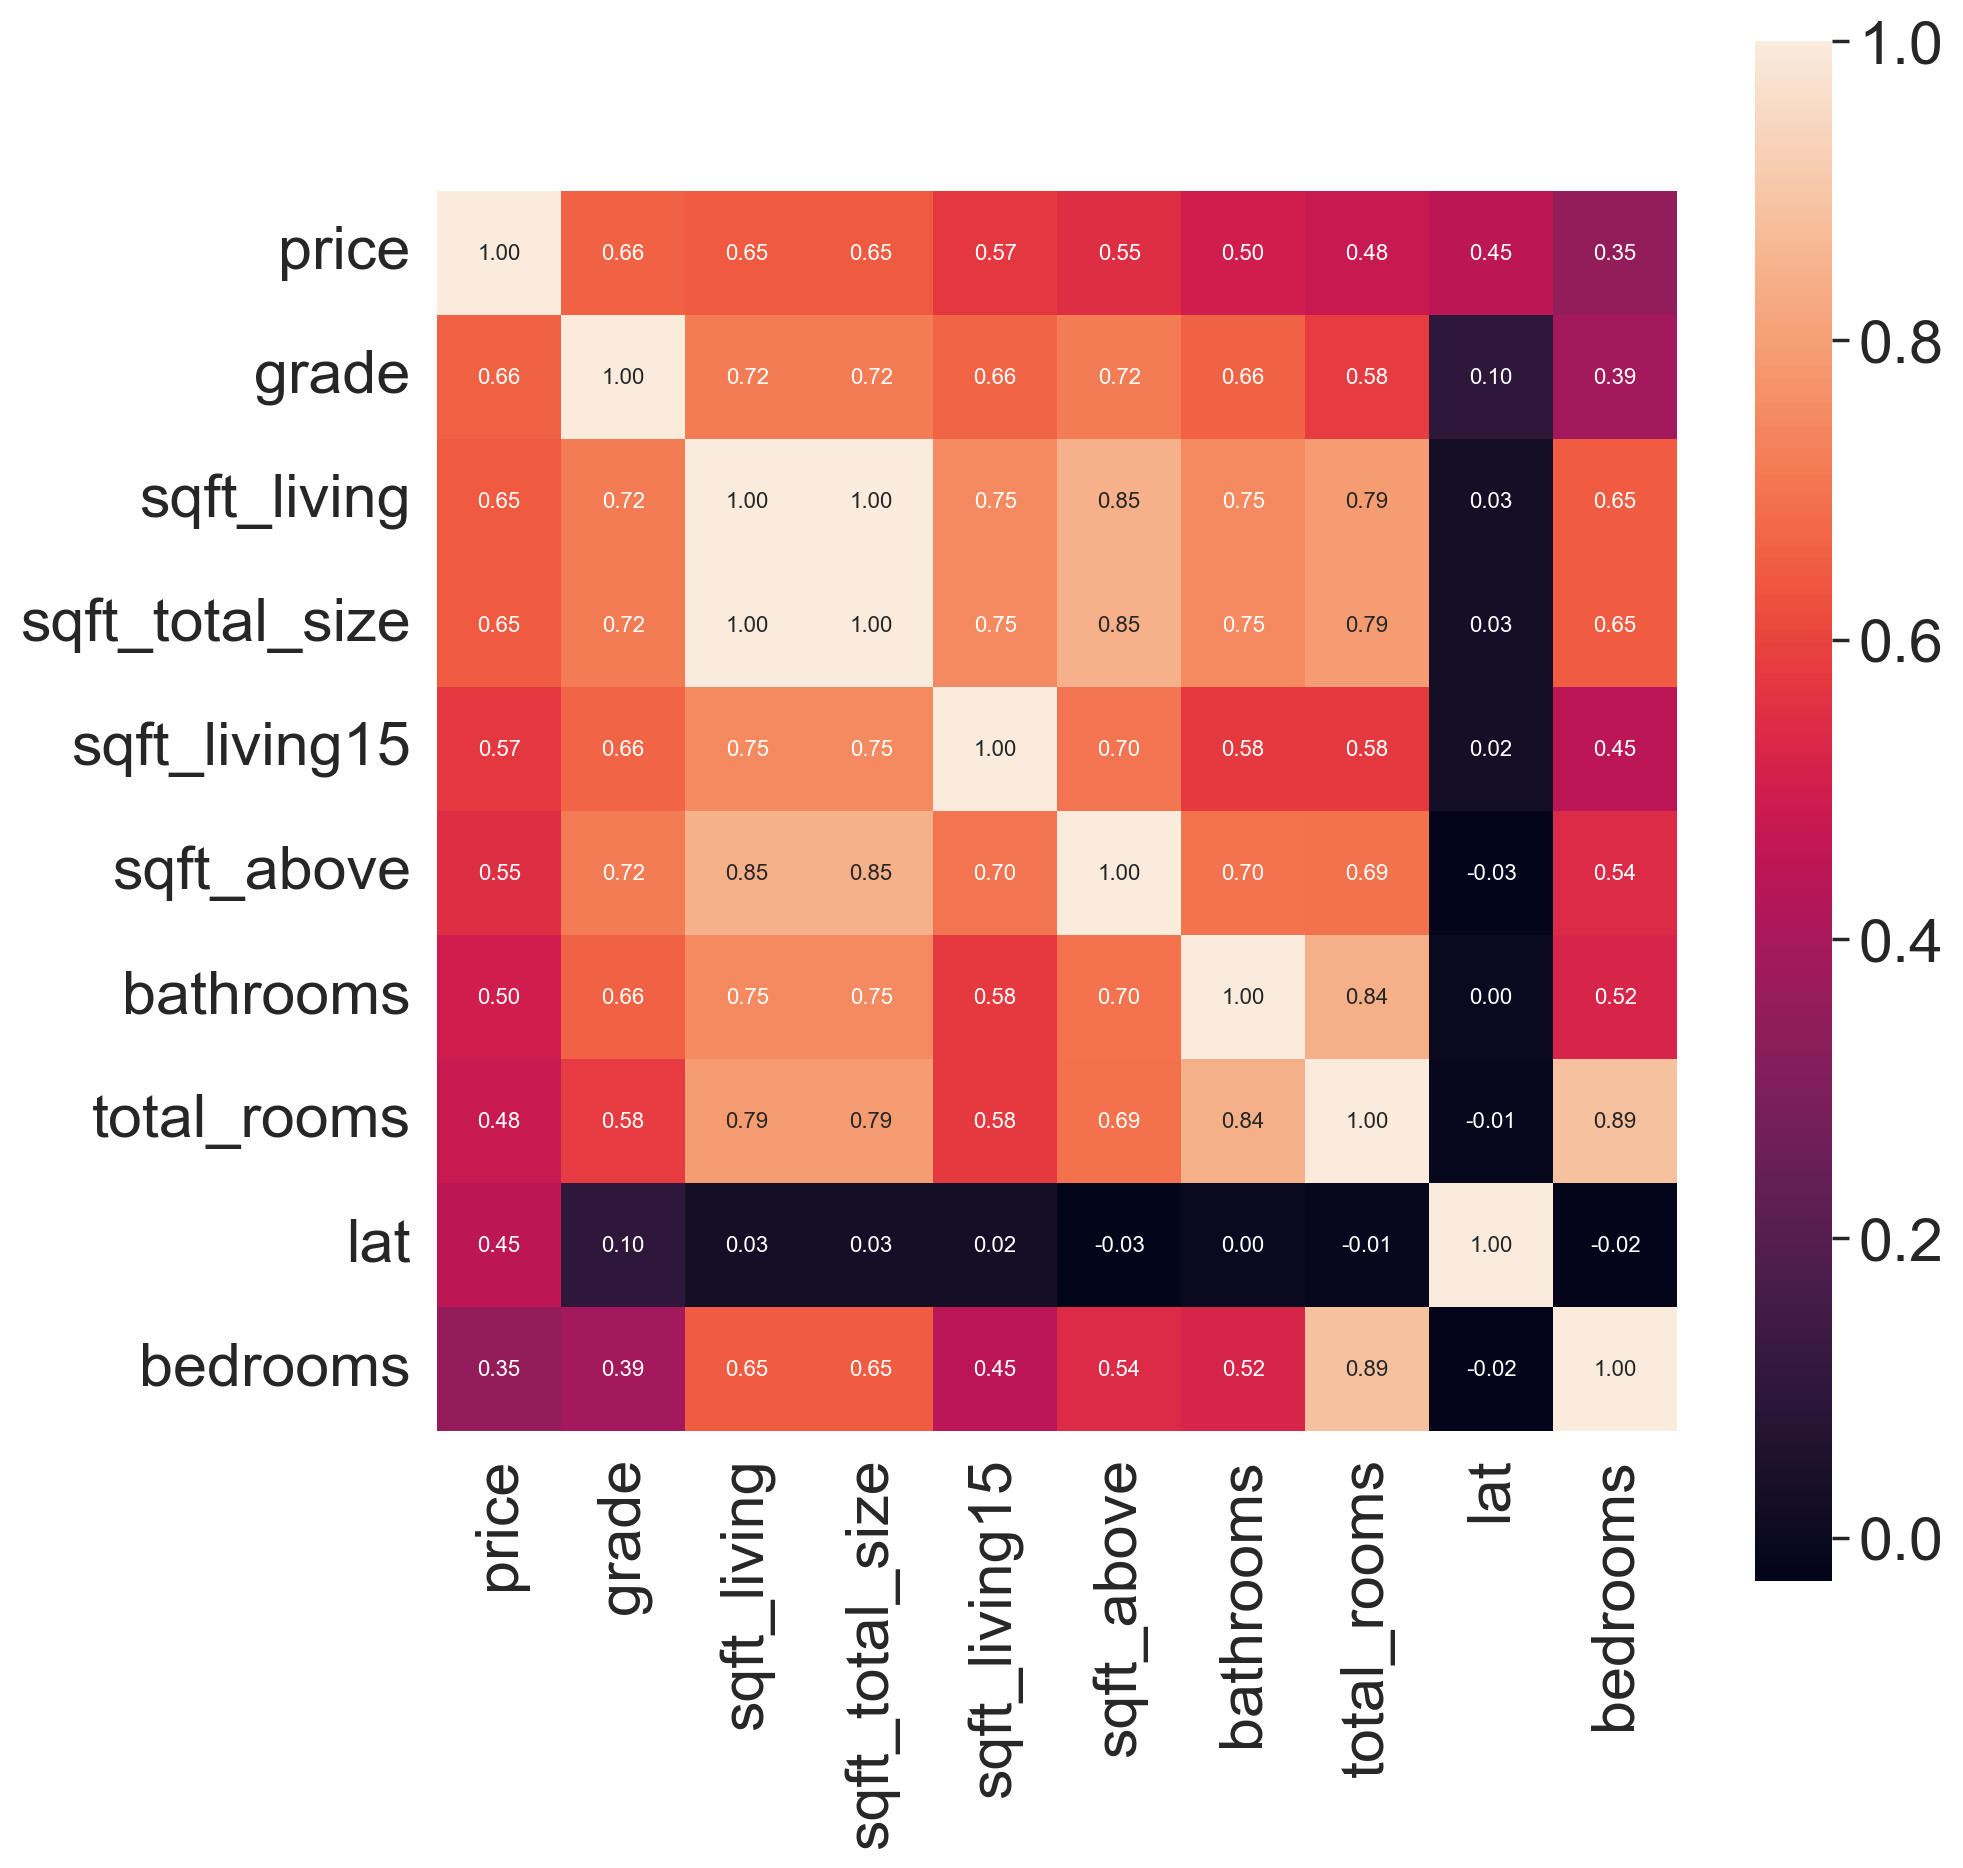

In [40]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
# price와 correlation이 높은 column 10개 뽑기(내림차순)
cor_cols = cor_abs.nlargest(n=10, columns='price').index

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8},
           xticklabels=cor_cols.values, yticklabels=cor_cols.values)

'sqft_total_size' 'total_rooms' 가 추가되면서 'floors'와 'view'가 빠짐.

위 자료는 [여기](https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12)에서 참고함

## step 3 모델 튜닝_RMSE 계산

__3.1 데이터 정리__

In [41]:
del train['price']
test_id = test['id']
del test['id']

이상치 처리 중 train 데이터에서 삭제한 행은 y(집값 라벨 데이터) 에서도 삭제

In [58]:
y.drop([12346, 7173, 2775, 8912, 5858, 6666, 12969, 8630, 11144, 7969, 6039, 11701, 2859, 5990, 10152], axis=0, inplace=True)
y.shape

(15020,)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [43]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [44]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [59]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df
get_scores(models, train, y)   

,RMSE
GradientBoostingRegressor,148471.855254
RandomForestRegressor,130875.051535
XGBRegressor,124773.725867
LGBMRegressor,117354.258549


__아무런 전처리도 하지 않은 데이터보다 RMSE 값이 높음__
1. Feature 새로 조합하기 전 데이터셋에서 price와 상관관계가 높은 top 10 feature만 가지고 테스트
2. Feature 새로 조합한 후 데이터셋에서 price와 상관관계가 높은 top 10 feature만 가지고 테스트

__3.1.1 Feature 새로 조합 전 데이터셋의 top10 feature 만 반영__
* 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms' 'lat' 'bedrooms' 'floors' 'view'

In [72]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,...,47.5112,-122.257,1340,5650,4.00,0.208850,1180,1.0,0.237168,1
1,201502,2,1.00,770,10000,1.0,0,0,3,6,...,47.7379,-122.233,2720,8062,3.00,0.077000,770,1.0,0.337385,1
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,...,47.6168,-122.045,1800,7503,5.00,0.207921,1680,1.0,0.239904,1
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,...,47.3097,-122.327,2238,6819,5.25,0.251503,1715,1.0,0.328201,1
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,...,47.4095,-122.315,1650,9711,4.50,0.109155,1060,1.0,0.169910,1


In [73]:
train2 = train[['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'floors', 'view']]
train2.head()

,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view
0,7,1180,1340,1180,1.00,47.5112,3,1.0,0
1,6,770,2720,770,1.00,47.7379,2,1.0,0
2,8,1680,1800,1680,2.00,47.6168,3,1.0,0
3,7,1715,2238,1715,2.25,47.3097,3,2.0,0
4,7,1060,1650,1060,1.50,47.4095,3,1.0,0


In [76]:
test2 = test[['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'floors', 'view']]
test2.head()

,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view
0,7,2570,1690,2170,2.25,47.7210,3,2.0,0
1,7,1960,1360,1050,3.00,47.5208,4,1.0,0
2,11,5420,4760,3890,4.50,47.6561,4,1.0,0
3,7,1780,1780,1050,1.00,47.5123,3,1.0,0
4,7,1890,2390,1890,2.50,47.3684,3,2.0,0


In [80]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train2, y, test_size=0.2, random_state=random_state)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, train2, y)   

,RMSE
GradientBoostingRegressor,170966.893467
RandomForestRegressor,167499.588665
LGBMRegressor,166770.993713
XGBRegressor,164091.934716


__3.1.2 Feature 새로 조합 후 데이터셋의 top10 feature 만 반영__
 * 'grade' 'sqft_living' 'sqft_total_size' 'sqft_living15' 'sqft_above' 'bathrooms' 'total_rooms' 'lat' 'bedrooms'

In [77]:
train3 = train[['grade', 'sqft_living', 'sqft_total_size', 'sqft_living15', 'sqft_above', 'bathrooms', 'total_rooms', 'lat', 'bedrooms']]
train3.head()

,grade,sqft_living,sqft_total_size,sqft_living15,sqft_above,bathrooms,total_rooms,lat,bedrooms
0,7,1180,1180,1340,1180,1.00,4.00,47.5112,3
1,6,770,770,2720,770,1.00,3.00,47.7379,2
2,8,1680,1680,1800,1680,2.00,5.00,47.6168,3
3,7,1715,1715,2238,1715,2.25,5.25,47.3097,3
4,7,1060,1060,1650,1060,1.50,4.50,47.4095,3


In [78]:
test3 = train[['grade', 'sqft_living', 'sqft_total_size', 'sqft_living15', 'sqft_above', 'bathrooms', 'total_rooms', 'lat', 'bedrooms']]
test3.head()

,grade,sqft_living,sqft_total_size,sqft_living15,sqft_above,bathrooms,total_rooms,lat,bedrooms
0,7,1180,1180,1340,1180,1.00,4.00,47.5112,3
1,6,770,770,2720,770,1.00,3.00,47.7379,2
2,8,1680,1680,1800,1680,2.00,5.00,47.6168,3
3,7,1715,1715,2238,1715,2.25,5.25,47.3097,3
4,7,1060,1060,1650,1060,1.50,4.50,47.4095,3


In [89]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train3, y, test_size=0.2, random_state=random_state)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, train3, y)   

,RMSE
RandomForestRegressor,180898.084600
XGBRegressor,178486.630383
GradientBoostingRegressor,173937.375848
LGBMRegressor,172140.206838


__무슨 짓을 해도 아무것도 안한 raw 데이터의 RMSE 값이 가장 낮음__

__3.2 마지막으로 min-max scaling 정규화만 해보자 (train 데이터 이용)__

* 나중에 test 데이터도 똑같이 정규화 해주는 것 잊지 말기!

In [83]:
import pandas as pd
 
from sklearn.preprocessing import MinMaxScaler


In [86]:
scaler = MinMaxScaler(feature_range=(0,3)) ## 각 칼럼 데이터 값을 0~3 범위로 변환
scaler.fit(train) ## 각 칼럼 데이터마다 변환할 함수 생성
transformed_X = scaler.transform(train) ## fit에서 만들어진 함수를 실제로 데이터에 적용
type(transformed_X)

numpy.ndarray

In [90]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=random_state)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, transformed_X, y)   

,RMSE
GradientBoostingRegressor,148474.015733
RandomForestRegressor,130613.242686
XGBRegressor,124771.084753
LGBMRegressor,118618.504534


__3.2.1 Feature 새로 조합 전 데이터셋의 top10 feature 만 반영__

In [91]:
scaler = MinMaxScaler(feature_range=(0,3)) ## 각 칼럼 데이터 값을 0~3 범위로 변환
scaler.fit(train2) ## 각 칼럼 데이터마다 변환할 함수 생성
transformed_X2 = scaler.transform(train2) ## fit에서 만들어진 함수를 실제로 데이터에 적용
type(transformed_X2)

numpy.ndarray

In [92]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(transformed_X2, y, test_size=0.2, random_state=random_state)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, transformed_X2, y)   

,RMSE
GradientBoostingRegressor,170970.009791
RandomForestRegressor,167372.253271
LGBMRegressor,166765.126458
XGBRegressor,164093.335978


__3.2.2 Feature 새로 조합 후 데이터셋의 top10 feature 만 반영__

In [94]:
scaler = MinMaxScaler(feature_range=(0,3)) ## 각 칼럼 데이터 값을 0~3 범위로 변환
scaler.fit(train3) ## 각 칼럼 데이터마다 변환할 함수 생성
transformed_X3 = scaler.transform(train3) ## fit에서 만들어진 함수를 실제로 데이터에 적용
type(transformed_X3)

numpy.ndarray

In [95]:
random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(transformed_X3, y, test_size=0.2, random_state=random_state)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, transformed_X3, y)   

,RMSE
RandomForestRegressor,180919.315786
XGBRegressor,178213.922953
GradientBoostingRegressor,173860.112872
LGBMRegressor,171567.364864


__정말 무슨짓을 해도 RMSE 값이 원본 데이터보다 낮아지지 않음을 확인함. 뭘 단단히 잘못한 것 같다.__